In [1]:
import pickle
import numpy as np

# Previous version: 2023
# with open("./results/params_search_ppo.pickle", 'rb') as f:
#     result = pickle.load(f)
    
# Current version: 2024
with open("./results/params_search_PPO_solid.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

# 2023 version
indices = np.where(((b_limit == 1) * (q_limit == 1) * (n_limit == 1) * (f_limit == 1) * (tbr >= 1) * (tbr < 2)) == 1)
print("indices : ", indices[0])

indices :  [ 886 1012 1130 2225 2415 2433 4320 4369 5062]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


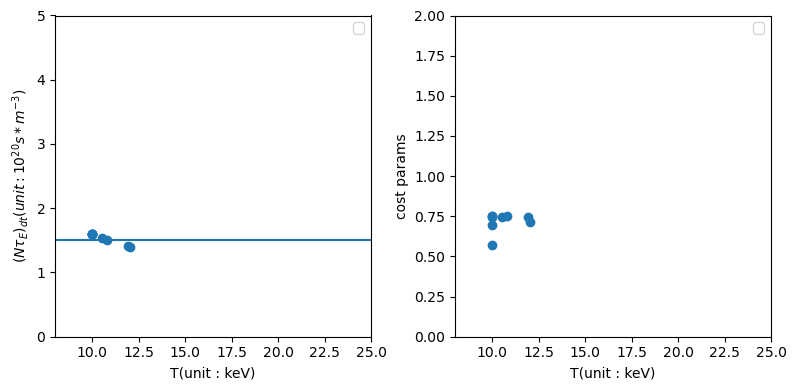

In [2]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [3]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 3.414
a : 0.966
blanket_thickness : 0.892
coil_thickness : 1.182
n : 2.162
TBR : 1.161
beta : 5.371
tau : 0.737
Ip : 9.297
q : 2.114
f_BS : 0.660
Q_parallel : 358.430
n_g : 3.169
q_kink : 2.000
beta_troyon : 5.403
f_NC : 0.729
n_tau : 1.594
n_tau_lower : 3.948
cost : 0.569
betan : 3.500
k : 1.900
epsilon : 3.533
electric_power : 502598815.918
T_avg : 10.000
B0 : 14.616
H : 1.300
armour_thickness : 0.010
RF_recirculating_rate : 0.200


### Gridsearch case

In [4]:
import pickle
import numpy as np

with open("./results/params_search_gridsearch_solid.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

indices = np.where(((b_limit == 1) * (q_limit == 1) * (n_limit == 1) * (f_limit == 1) * (tbr >= 1) * (tbr < 2)) == 1)
print("indices : ", indices[0])
print("# of cases : {}".format(len(indices[0])))

indices :  [1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1050 1051 1052 1053
 1054 1055 1056 1057 1058 1059 1080 1081 1082 1083 1084 1085 1086 1087
 1088 1089 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1150 1151
 1152 1153 1154 1155 1156 1157 1158 1159 1180 1181 1182 1183 1184 1185
 1186 1187 1188 1189 4020 4021 4022 4023 4024 4025 4026 4028 4029 4050
 4051 4052 4053 4054 4055 4056 4058 4059 4080 4081 4082 4083 4084 4085
 4086 4088 4089 8020 8021 8022 8023 8024 8025 8026 8027 8028 8029 8050
 8051 8052 8053 8054 8055 8056 8057 8058 8059 8080 8081 8082 8083 8084
 8085 8086 8087 8088 8089]
# of cases : 117


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


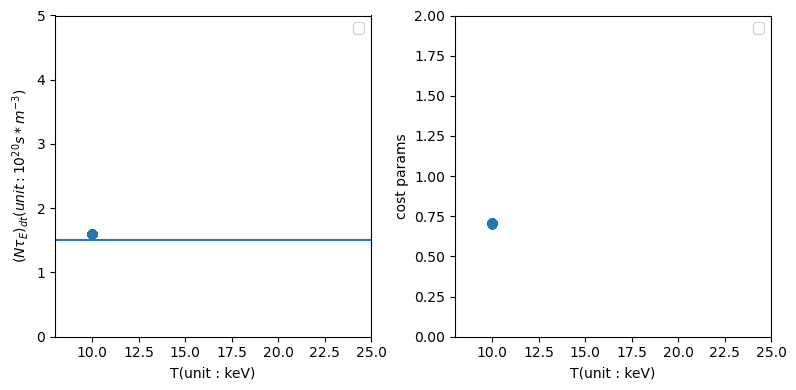

In [5]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [6]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 4.731
a : 1.310
blanket_thickness : 0.891
coil_thickness : 1.228
n : 1.857
TBR : 1.030
beta : 2.974
tau : 0.858
Ip : 12.195
q : 2.661
f_BS : 0.532
Q_parallel : 605.193
n_g : 2.261
q_kink : 2.000
beta_troyon : 2.998
f_NC : 0.661
n_tau : 1.594
n_tau_lower : 4.272
cost : 0.703
betan : 2.500
k : 1.900
epsilon : 3.611
electric_power : 944444444.444
T_avg : 10.000
B0 : 15.111
H : 1.000
armour_thickness : 0.011
RF_recirculating_rate : 0.144


### Reward shape engineering

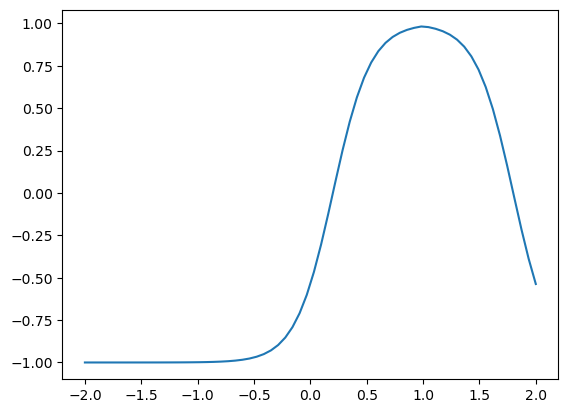

In [15]:
import math

def compute_sigmoid(x):
    return math.tanh(x)

def reward_func(x, scale, a, x_min, x_max):
    xn = x / scale
    xnl = x_min / scale
    xrl = x_max / scale
    
    if xn < xrl:
        reward = compute_sigmoid(a * (xn - xnl))
    else:
        reward = compute_sigmoid(a * (2 * xrl - xnl - xn))
        
    return reward

x = np.linspace(-2,2,64)
y = np.array([reward_func(t, 1, 3, 0.2, 1.0) for t in x])

plt.plot(x,y)